Dataset not included due to size.
Download link: https://www.kaggle.com/datasets/gangadhar/nuclei-segmentation-in-microscope-cell-images


Total Images: 664

Processing...

4ca5081854df7bbcaa4934fcf34318f82733a0f8c05b942c2265eea75419d62f.jpg | No Marker: 0.1565 | With Marker: 0.0196
866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855.jpg | No Marker: 0.0130 | With Marker: 0.9054
308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722.jpg | No Marker: 0.1480 | With Marker: 0.7340
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d.jpg | No Marker: 0.3332 | With Marker: 0.9535
f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1.jpg | No Marker: 0.5198 | With Marker: 0.7993
9a71a416f98971aa14f63ef91242654cc9191a1414ce8bbd38066fe94559aa4f.jpg | No Marker: 0.0460 | With Marker: 0.9018
df33b11184427e05c8a450f921586685975fe975f57315e686a0f26fddb93db1.jpg | No Marker: 0.1647 | With Marker: 0.8647
6034456567632f4b48dc3dfbb98534b5953c151990f4235df6c912c0a9c08397.jpg | No Marker: 0.0786 | With Marker: 0.9336
b0d6dfcc95e4d087d232378f860fc3ef9f95ea5a4c26d623a0be091f820a793f.jpg | No Mark

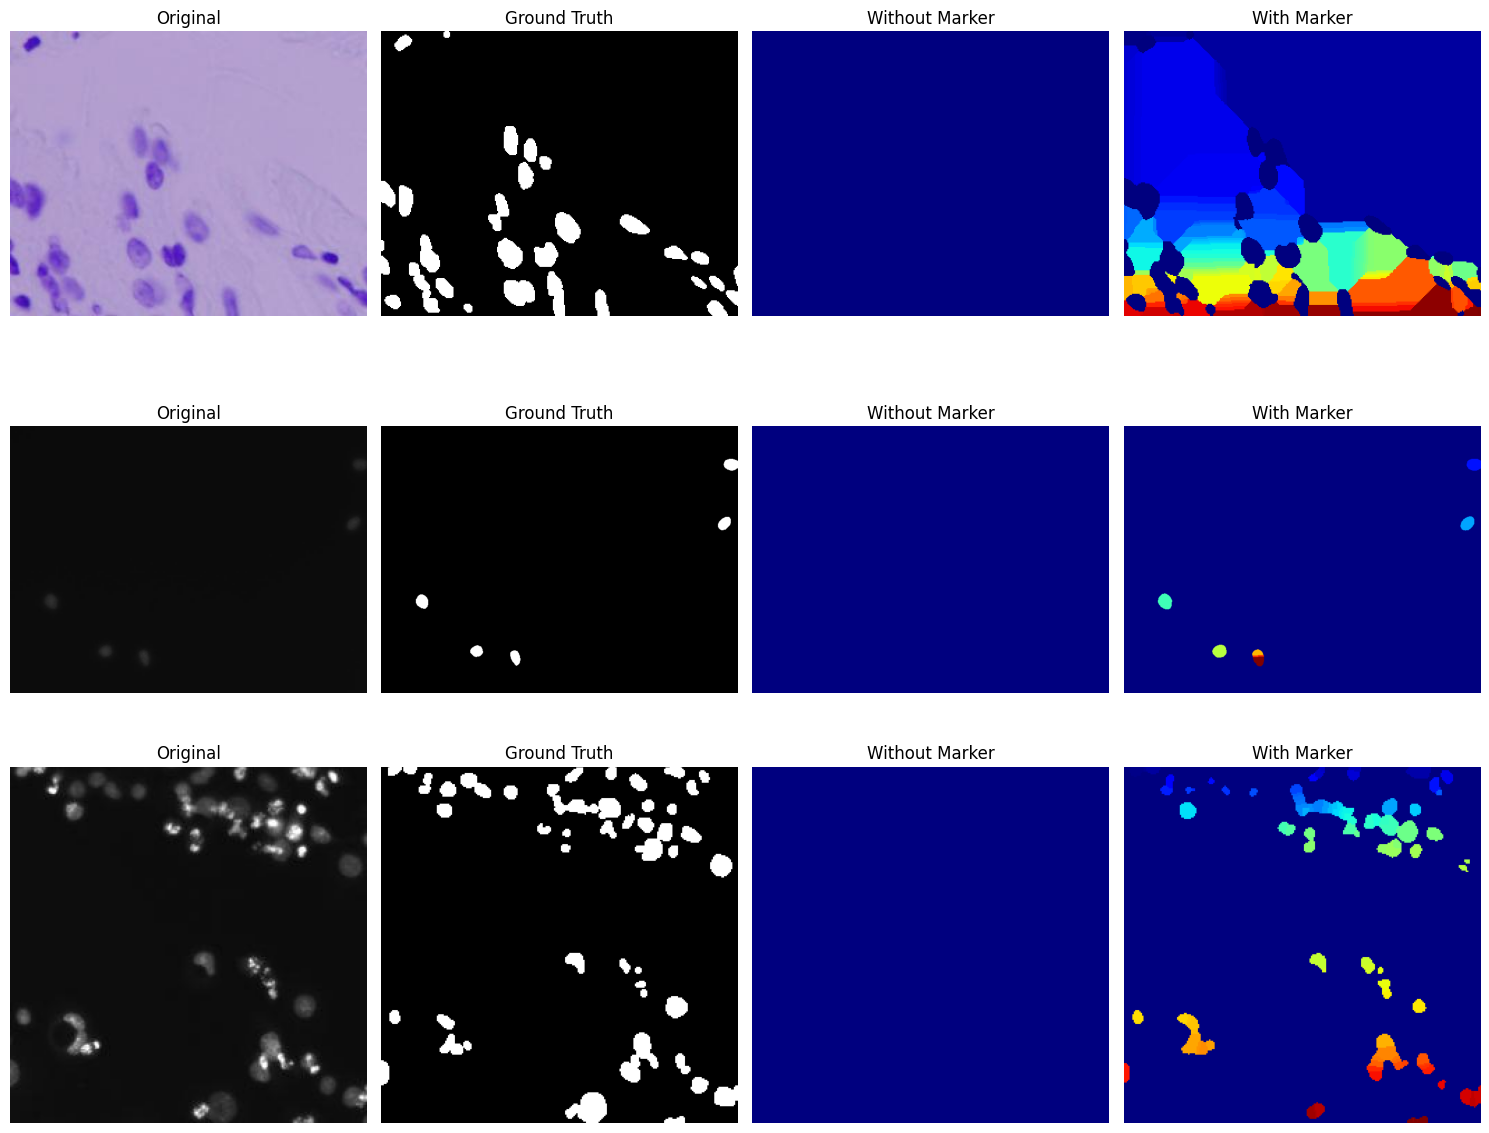

In [4]:
# ==========================================
# DLMI PROJECT 4
# Watershed Nuclei Separation
# COCO Dataset (Stage 1 Train)
# ==========================================

!pip install -q opencv-python pycocotools scikit-image matplotlib numpy


# -------------------------------
# Imports
# -------------------------------
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

from pycocotools import mask as mask_util
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# -------------------------------
# Paths
# -------------------------------
IMG_PATH = "/content/Nuclei/Nuclei/stage_1_train"
ANN_FILE = "/content/Nuclei/Nuclei/annotations/stage1_train.json"


# -------------------------------
# Load COCO
# -------------------------------
COCO = json.load(open(ANN_FILE))

images_meta = COCO["images"]
annotations = COCO["annotations"]

print("Total Images:", len(images_meta))


# -------------------------------
# Get Mask for One Image
# -------------------------------
def get_mask(image_id, h, w):

    masks = []

    for ann in annotations:

        if ann["image_id"] == image_id:

            seg = ann["segmentation"]

            # If segmentation is RLE
            if isinstance(seg, dict):

                mask = mask_util.decode(seg)

            # If segmentation is polygon
            else:

                rle = mask_util.frPyObjects(seg, h, w)
                mask = mask_util.decode(rle)

            if len(mask.shape) == 3:
                mask = np.sum(mask, axis=2)

            masks.append(mask)

    if len(masks) == 0:
        return np.zeros((h,w))

    final = np.sum(masks, axis=0)

    return (final > 0).astype(np.uint8)*255

# -------------------------------
# Preprocessing
# -------------------------------
def preprocess(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (5,5), 0)

    _, binary = cv2.threshold(
        blur, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    return binary


# -------------------------------
# Watershed (No Marker)
# -------------------------------
def watershed_no_marker(binary):

    dist = ndi.distance_transform_edt(binary)

    labels = watershed(-dist, binary)

    return labels


# -------------------------------
# Watershed (With Marker)
# -------------------------------
def watershed_with_marker(binary):

    dist = ndi.distance_transform_edt(binary)

    coords = peak_local_max(
        dist,
        footprint=np.ones((3,3)),
        labels=binary
    )

    mask = np.zeros(dist.shape, dtype=bool)
    mask[tuple(coords.T)] = True

    markers, _ = ndi.label(mask)

    labels = watershed(-dist, markers, mask=binary)

    return labels


# -------------------------------
# Dice Score
# -------------------------------
def dice(a, b):

    a = a > 0
    b = b > 0

    inter = np.sum(a & b)

    return (2*inter)/(np.sum(a)+np.sum(b)+1e-8)


# -------------------------------
# Run Experiment (10 Images)
# -------------------------------
dice_no = []
dice_yes = []

orig = []
res_no = []
res_yes = []
gt_all = []

print("\nProcessing...\n")

for i in range(10):

    meta = images_meta[i]

    name = meta["file_name"]

    h = meta["height"]
    w = meta["width"]
    img_id = meta["id"]

    img = cv2.imread(os.path.join(IMG_PATH, name))

    gt = get_mask(img_id, h, w)

    binary = preprocess(img)

    no_m = watershed_no_marker(binary)
    yes_m = watershed_with_marker(binary)

    d_no = dice(no_m, gt)
    d_yes = dice(yes_m, gt)

    dice_no.append(d_no)
    dice_yes.append(d_yes)

    orig.append(img)
    res_no.append(no_m)
    res_yes.append(yes_m)
    gt_all.append(gt)

    print(f"{name:25s} | No Marker: {d_no:.4f} | With Marker: {d_yes:.4f}")


print("\nDone ✅")


# -------------------------------
# Final Results
# -------------------------------
print("\n========== RESULTS ==========\n")

print("Without Marker Avg:", np.mean(dice_no))
print("With Marker Avg   :", np.mean(dice_yes))

print("\n=============================")


# -------------------------------
# Visualization
# -------------------------------
plt.figure(figsize=(15,12))

for i in range(3):

    plt.subplot(3,4,i*4+1)
    plt.imshow(cv2.cvtColor(orig[i], cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(3,4,i*4+2)
    plt.imshow(gt_all[i], cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3,4,i*4+3)
    plt.imshow(res_no[i], cmap="jet")
    plt.title("Without Marker")
    plt.axis("off")

    plt.subplot(3,4,i*4+4)
    plt.imshow(res_yes[i], cmap="jet")
    plt.title("With Marker")
    plt.axis("off")


plt.tight_layout()
plt.show()
